In [2]:
import path
import libs.checker as checker
from control import *
from z3 import *
from scipy.signal import lti, step, impulse
import scipy.signal as sig
from matplotlib import pyplot as p

This example is borrowed and adapted from [1], design problem 5.4 on Pg. 360. The following transfer function represents the control system of a simplified space satellite to readjust its orientation:
$$ L(s) = \frac{10K}{(s+3)(s+7)(s+70)} = \frac{10K/70}{(s+3)(s+7)(s/70+1)}$$

[1] Richard C.. Dorf, and Robert H. Bishop. Modern control systems. Pearson Prentice Hall, 2016. Pg. 360

With $K = 500$, does the system can expect steady state error $e_{ss} \le 12\%$ to a step input?

By droping fast dynamics at pole $70$, and compensate for the dc gain, we have the following approximation:
$$ \hat{L}(s) = \frac{K/7}{(s+3)(s+7)}$$

The original closed-loop transfer function is given by:

$$ H(s) = \frac{L(s)}{1+L(s)} = \frac{10K}{(s+3)(s+7)(s+70)+10K}$$

The approximated closed-loop transfer function is given by:
$$\hat{H}(s) = \frac{\hat{L}(s)}{1+\hat{L}(s)} = \frac{K/7}{(s+3)(s+7)+K/7}$$ 

In [3]:
# Constants
K = 500
r = 1

# Original Transfer function
Hs_num = [10*K]
Hs_den = [1, 80, 721,1470+10*K]
Hs = lti(Hs_num, Hs_den)
t, s = step(Hs)

# Approximated transfer function
Hs_hat_num = [K/7]
Hs_hat_den = [1, 10, 21+K/7]
Hs_hat = lti(Hs_hat_num, Hs_hat_den)
t2, s2 = step(Hs_hat)

In [4]:
# Chars calculation
wn_square = Hs_hat_den[-1]
two_zeta_wn = Hs_hat_den[-2]

omega_n = math.sqrt(wn_square)
zeta = two_zeta_wn/(2*omega_n)

print(f'zeta = {zeta}, omega_n = {omega_n}')


zeta = 0.5200760852671171, omega_n = 9.613977919080709


In [5]:

# Setup
c = checker.Checker(zeta,omega_n,1)


As the given transfer function is not standard 2nd-order (i.e. with attenuated gain), the easiest way is to static checking it against attenuated safety requirement accordingly.

In [6]:

# Safety
f = c.factory
factor = K / (K + 147) 
att_steady = f.steady * factor
safety = And(att_steady-r <= 0.12, att_steady-r>=-0.12)

# PO Generation
c.auto_pog(safety)

In [7]:
# Numerical Static Checking in Z3 SMT solver
c.result()

static checking result =  sat
static checking model =  [y = Store(Store(Store(K(Real, 0.9), -38, 0),
                 0.3825849601?,
                 1.1476479137?),
           7719,
           0.1),
 ft = -38,
 t2 = 7719,
 input = 1,
 steady = 1,
 rise = 0.1792561163?,
 settle = 0.9210340371?,
 peak = 0.3825849601?,
 overshoot = 0.1476479137?,
 dc = 1]


Here, the solver return sat, which suggests a counter example is found. 

Let us first examine the approximated and the original transfer functions by plotting:

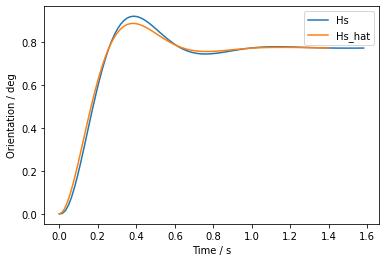

In [8]:
p.plot(t, s, label='Hs')
p.plot(t2,s2, label='Hs_hat')
p.xlabel('Time / s')
p.ylabel('Orientation / deg')
p.legend()
p.show()


It shows the apprximation preserves the significant dynamics of the original one. 

Then, let us examing the counterexample, from the static checking result of the approximation, it suggests that we will expect the steady-state value of the original system is at $0.77$ (i.e. $23$% steady-state error), which is not within tolerable steady-state error range ($< 12$% w.r.t. step input of amplitute $1$).

In [9]:
stdy = c.model(f.steady)*factor
print(f"steady state = {stdy}, steady state error = {abs(stdy-r)}")



steady state = 0.7727975270479135, steady state error = 0.2272024729520865
